# CSCI 6515 Final Project
## Model and Evaluation Component
## Noah Sealy, B00726289

# Imports

In [1]:
# reading data
import dask.dataframe as dd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# preprocessing
import nltk
from nltk.stem import WordNetLemmatizer 
import dask_ml.feature_extraction.text
from sklearn.feature_extraction.text import TfidfVectorizer

# model
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from dask.distributed import Client
import joblib
from sklearn.datasets import load_digits
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# evaluation
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix

In [2]:
# use dask to read data file
df = dd.read_csv('dash-app/Hotel_Reviews.csv')

# Data Investigation
## This section does not require execution if you are just trying to run the model
## In that case, you can skip to the Data Preprocessing section

In [3]:
# shows the available data columns of the Hotel Review data set
print(df.columns)

Index(['Hotel_Address', 'Additional_Number_of_Scoring', 'Review_Date',
       'Average_Score', 'Hotel_Name', 'Reviewer_Nationality',
       'Negative_Review', 'Review_Total_Negative_Word_Counts',
       'Total_Number_of_Reviews', 'Positive_Review',
       'Review_Total_Positive_Word_Counts',
       'Total_Number_of_Reviews_Reviewer_Has_Given', 'Reviewer_Score', 'Tags',
       'days_since_review', 'lat', 'lng'],
      dtype='object')


In [4]:
# example of review scores
print(df['Reviewer_Score'].head())

0    2.9
1    7.5
2    7.1
3    3.8
4    6.7
Name: Reviewer_Score, dtype: float64


In [5]:
# example of average hotel score
# the data printed is probably all from the same hotel, thus they have the same average hotel score
print(df['Average_Score'].head())

0    7.7
1    7.7
2    7.7
3    7.7
4    7.7
Name: Average_Score, dtype: float64


In [6]:
# calculate the hotel average score as well as the average review score for each hotel
# this data will represent the hotel average score and average review score pairs
av_scores = df.groupby('Hotel_Name').Reviewer_Score.agg(['mean', 'count'])
hotel_scores = df.groupby('Hotel_Name').Average_Score.agg(['mean', 'count'])

In [7]:
av_scores.compute()
print(av_scores.head())
hotel_scores.compute()
print(hotel_scores.head())

                                 mean  count
Hotel_Name                                  
11 Cadogan Gardens           8.845283    159
1K Hotel                     7.861486    148
Ace Hotel London Shoreditch  8.683074    514
Amarante Champs Elys es      7.620588    102
Ambassadors Bloomsbury       7.845833    768
                             mean  count
Hotel_Name                              
11 Cadogan Gardens            8.7    159
1K Hotel                      7.7    148
Ace Hotel London Shoreditch   8.6    514
Amarante Champs Elys es       7.7    102
Ambassadors Bloomsbury        7.9    768


In [8]:
# calculate correlation between the hotel average score and average review score pairs
# disregard the warning, as the data is all coming from the same place, it is safe
corr = av_scores['mean'].corr(hotel_scores['mean'])

/opt/anaconda3/lib/python3.8/site-packages/dask/dataframe/multi.py:1094: UserWarning: Concatenating dataframes with unknown divisions.
We're assuming that the indexes of each dataframes are 
 aligned. This assumption is not generally safe.
  warnings.warn(


In [9]:
# calculate correlation between the hotel average score and average review score pairs
cor = corr.compute()
print(cor)

0.963595031796609


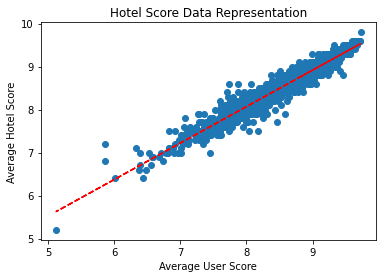

In [10]:
# this will map each hotel average score and average review score pair
# some of this code was retrived from the stack overflow answer post as shown below
# https://stackoverflow.com/a/26447505/12617155
# this plot uses matplotlib
fig, ax = plt.subplots()

x = av_scores['mean'].compute()
y = hotel_scores['mean'].compute()

# red line to further show linear correlation
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x, p(x), "r--")

# plot
ax.scatter(x, y)
ax.set(xlabel='Average User Score', 
       ylabel='Average Hotel Score',
       title='Hotel Score Data Representation')
plt.show()

# Data Preprocessing

In [11]:
# assign Negative polarity to reviews with a review score lower than 5, depicted as 0
# assign Positive polarity to reviews with a review score greater or equal to 5, depicted as 1
df['Polarity'] = 0
df['Polarity'] = df['Polarity'].mask(df['Reviewer_Score'] < 5, 0)
df['Polarity'] = df['Polarity'].mask(df['Reviewer_Score'] >= 5, 1)
print(df['Reviewer_Score'].head())
print(df['Polarity'].head())

0    2.9
1    7.5
2    7.1
3    3.8
4    6.7
Name: Reviewer_Score, dtype: float64
0    0
1    1
2    1
3    0
4    1
Name: Polarity, dtype: int64


In [12]:
# balance the data set
# select data from march of 2017, or with a polarity of 0
# this will leave use with ~20k positive reviews and ~20k negative
month = 3
year = 2017
df = df[(df['Review_Date'].str.match(str(month) + '/' + r'[\d]{1,2}' + '/' + str(year))) | (df['Polarity'] == 0)]

count = 0
for looking in df['Polarity']:
    count += 1

print(df.head())

                                        Hotel_Address  \
0    s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
3    s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
6    s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
12   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
21   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   

    Additional_Number_of_Scoring Review_Date  Average_Score   Hotel_Name  \
0                            194    8/3/2017            7.7  Hotel Arena   
3                            194   7/31/2017            7.7  Hotel Arena   
6                            194   7/17/2017            7.7  Hotel Arena   
12                           194    7/6/2017            7.7  Hotel Arena   
21                           194   6/12/2017            7.7  Hotel Arena   

   Reviewer_Nationality                                    Negative_Review  \
0               Russia    I am so angry that i made this post available...   
3       United Kingdom    My room was dirty 

In [13]:
# analyze the counts of the balanced data set
zeros = 0
ones = 0
size = 0
for looking in df['Polarity']:
    if looking == 0:
        zeros += 1
    else:
        ones += 1
    size += 1

print('Total Reviews Reviews: ' + str(size))
print('Positive Reviews: ' + str(ones))
print('Negative Reviews: ' + str(zeros))

Total Reviews Reviews: 41833
Positive Reviews: 19552
Negative Reviews: 22281


In [14]:
# combine the negative and positive text reviews
# if a text review is not there, ignore it
df['Full_Text'] = ""
# remove the No Negative and No Positive from review text, as that will just add bad noise to the data
df['Full_Text'] = df['Full_Text'].mask(df['Negative_Review'] == 'No Negative', df['Positive_Review'])
df['Full_Text'] = df['Full_Text'].mask(df['Positive_Review'] == 'No Positive', df['Negative_Review'])
df['Full_Text'] = df['Full_Text'].mask(df['Full_Text'] == "", df['Positive_Review'] + df['Negative_Review'])

In [15]:
# an example of the above combination
print(df['Positive_Review'].head())
print(" ")
print(df['Negative_Review'].head())
print(" ")
print(df['Full_Text'].head())

0      Only the park outside of the hotel was beauti...
3      Great location in nice surroundings the bar a...
6      The room is spacious and bright The hotel is ...
12                             Comfy bed good location 
21     The breakfast was the only positive element o...
Name: Positive_Review, dtype: object
 
0      I am so angry that i made this post available...
3      My room was dirty and I was afraid to walk ba...
6      Cleaner did not change our sheet and duvet ev...
12     The floor in my room was filfy dirty Very bas...
21     Our room was an overrated disaster room 231 d...
Name: Negative_Review, dtype: object
 
0      Only the park outside of the hotel was beauti...
3      Great location in nice surroundings the bar a...
6      The room is spacious and bright The hotel is ...
12     Comfy bed good location  The floor in my room...
21     The breakfast was the only positive element o...
Name: Full_Text, dtype: object


In [16]:
# function to remove stop words, lemmatize words, and convert them to lower case
stop_words = set(nltk.corpus.stopwords.words('english'))
lemmatizer = WordNetLemmatizer() 

def remove_stop_lemmatize(text):
    text = text.split(' ')
    return ' '.join(lemmatizer.lemmatize(word.lower()) for word in text if word.lower() not in stop_words)

In [17]:
# test it out
check = 'No real complaints the hotel was great great location surroundings rooms amenities and service Two recommendations however firstly the staff upon check in are very confusing regarding deposit payments and the staff offer you upon checkout to refund your original payment and you can make a new one Bit confusing Secondly the on site restaurant is a bit lacking very well thought out and excellent quality food for anyone of a vegetarian or vegan background but even a wrap or toasted sandwich option would be great Aside from those minor minor things fantastic spot and will be back when i return to Amsterdam '
check = remove_stop_lemmatize(check)
print(check)

real complaint hotel great great location surroundings room amenity service two recommendation however firstly staff upon check confusing regarding deposit payment staff offer upon checkout refund original payment make new one bit confusing secondly site restaurant bit lacking well thought excellent quality food anyone vegetarian vegan background even wrap toasted sandwich option would great aside minor minor thing fantastic spot back return amsterdam 


In [18]:
# function to apply the remove_stop_lemmatize function to a whole dataframe
def clean_text (df):
    df['Processed_Full'] = df.Full_Text.map(lambda text:text).map(remove_stop_lemmatize)
    return df

In [19]:
# intialize the column
df['Processed_Full'] = ''

In [20]:
# apply the clean_text function to each partition of the data frame
# thus, the combined text will be preprocessed!
result = df.map_partitions(clean_text, meta=df)
df = result.compute()

In [21]:
# example of the preprocossed text
print(df['Processed_Full'].head())

0      park outside hotel beautiful  angry made post...
3      great location nice surroundings bar restaura...
6      room spacious bright hotel located quiet beau...
12     comfy bed good location  floor room filfy dir...
21     breakfast positive element hotel original tas...
Name: Processed_Full, dtype: object


# Model Training

In [22]:
# convert the processed text data into word vectors
vectorizer = TfidfVectorizer(min_df = 5,
                             max_df = 0.8,
                             sublinear_tf = True,
                             use_idf = True)

vectors = vectorizer.fit_transform(df['Processed_Full'])

In [23]:
# throw these word vectors into the data frame
df['Text_Vectors'] = vectors

In [24]:
# the input text values are now ready for the model
# the labels to the input text is the polarity of the review
X = vectors
y = df['Polarity']

In [25]:
# set up grid search for training
# this will train the support vector machine, with the given hyperparameters, and return the best
param_grid = {"C": [0.01, 0.1, 1, 5],
              "kernel": ['linear'],
              "shrinking": [True, False]}

grid_search = GridSearchCV(SVC(gamma='auto', random_state=0, probability=False),
                           param_grid=param_grid,
                           return_train_score=False,
                           iid=True,
                           cv=3,
                           n_jobs=-1)

In [26]:
# split the data into training and testing sets
# the testing set will have 30% of the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

In [27]:
# set up the joblib client
client = Client() 

In [28]:
# using joblib parrallelization, execute the grid search training
with joblib.parallel_backend('dask'):
    grid_search.fit(X_train, y_train)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


# Model Evaluation

In [29]:
# put the results in a data frame
results = pd.DataFrame(grid_search.cv_results_)
print(results)

   mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
0     101.726224      1.945826        42.325075        0.546003    0.01   
1      92.431201      1.451605        42.278900        0.201165    0.01   
2      65.057794      0.236189        27.166294        0.119313     0.1   
3      61.123675      0.268929        27.189791        0.240826     0.1   
4      55.615300      0.643545        19.648606        0.133778       1   
5      59.143214      0.884248        19.972596        0.378266       1   
6     126.988443      2.302418        17.840719        0.432418       5   
7     135.569305     16.785944        11.759765        1.571987       5   

  param_kernel param_shrinking  \
0       linear            True   
1       linear           False   
2       linear            True   
3       linear           False   
4       linear            True   
5       linear           False   
6       linear            True   
7       linear           False   

                 

In [30]:
# use the now trained model to predict the unseen test data
y_pred = grid_search.predict(X_test)

In [31]:
# evaluate the above predictions
print('Accuracy Score : ' + str(accuracy_score(y_test, y_pred)))
print('Precision Score : ' + str(precision_score(y_test, y_pred)))
print('Recall Score : ' + str(recall_score(y_test, y_pred)))
print('F1 Score : ' + str(f1_score(y_test, y_pred)))

print('Confusion Matrix : \n' + str(confusion_matrix(y_test, y_pred)))

Accuracy Score : 0.8359362549800797
Precision Score : 0.8444444444444444
Recall Score : 0.7936997089539463
F1 Score : 0.8182861177301208
Confusion Matrix : 
[[5855  854]
 [1205 4636]]


# Custom Model Input

In [39]:
# this section provides a way to directly interact with the trained model
# simply change input_text to see what the model predicts the polarity of the text is!
input_text = 'The service was not great'
pre_process = remove_stop_lemmatize(input_text)
process = vectorizer.transform([pre_process])

result = grid_search.predict(process)

if result == 1:
    print('Input: ' + input_text)
    print('Polarity: Positive')
else:
    print('Input: ' + input_text)
    print('Polarity: Negative')

Input: The service was not great
Polarity: Positive
